# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)

### 0. Импорт библиотек

In [1]:
# Работа с данными
import pandas as pd
import numpy as np

# Датасет
from sklearn import datasets

# Дополнительные фичи
from sklearn.model_selection import train_test_split

# Модели 
from sklearn.tree import DecisionTreeClassifier

# Работа с метаданными
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV

#Визуализации
import seaborn as sns
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style()
import matplotlib.pyplot as plt
import plotly

# Сохранение модели
import pickle

/Users/akirichenko/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/akirichenko/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### 1. Работа с данными

In [2]:
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
gender_submission = pd.read_csv('data/gender_submission.csv')

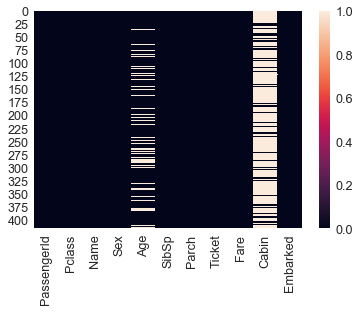

In [3]:
sns.heatmap(test.isna())

In [4]:
# Создание новых признаков
columns = ['Pclass', 'Sex', 
           'SibSp', 'Parch', 'Fare', 'Embarked',
           'has_cabin', 'new_age']

def update_titanic_data_for_ml(df):
    new_df = df
    new_df['has_cabin'] = df['Cabin'].isna()*1
    new_df['name_prefix'] =  df['Name'].str.extract(', (.*?)\.')
    new_df['new_age'] = new_df.fillna(-1).apply(lambda row: train.groupby('name_prefix').mean()['Age'][row['name_prefix']] 
                                                                if row['Age'] == -1 
                                                            else row['Age'], axis=1)
    new_df['Fare'] = new_df.fillna(-1).apply(lambda row: train.groupby('Pclass').mean()['Fare'][row['Pclass']]
                                                             if row['Fare'] == -1
                                                            else row['Fare'], axis=1)
    new_df['Sex'] = new_df.apply(lambda row: 1 if row['Sex'] == 'male' else 0, axis=1)
    return new_df

In [5]:
def X_y_split(df):
    data = df[columns]

    cat_columns = ['Embarked', 'Pclass']
    X = data.drop(cat_columns, axis=1)

    for i in cat_columns:
        new_columns = pd.get_dummies(data[i], prefix=i)
        X = pd.concat([X, new_columns], axis=1)
        
    if df.columns.contains('Survived'):
        return X, df['Survived']
    else:
        return X

X, y = X_y_split(update_titanic_data_for_ml(train))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_kaggle_test = X_y_split(update_titanic_data_for_ml(test))

### 2. Модель - Дерево решений

In [6]:
tree_model = DecisionTreeClassifier()

min_samples_leafs = [1,2,3,4,5,6,7]
min_samples_splits = [2,3,4,5,6,7,8,9]
max_depths=[4,5,6,7,8,9,10,11,12,15,20,30]
criterions=['gini', 'entropy']
splitters=['best', 'random']

param_tree = dict(min_samples_leaf  = min_samples_leafs,
                  min_samples_split = min_samples_splits,
                  criterion=criterions,
                  max_depth=max_depths,
                  splitter=splitters)

In [7]:
grid_tree = GridSearchCV(tree_model, param_tree, cv=6)
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=6, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9], 'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30], 'splitter': ['best', 'random']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [8]:
grid_tree.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [9]:
grid_tree.best_estimator_.score(X_test, y_test)

0.8134328358208955

In [10]:
estimator = grid_tree.best_estimator_
estimator.score(X_test, y_test)

results = pd.DataFrame({'PassengerId': test['PassengerId'],
                        'Survived': estimator.predict(X_kaggle_test)})

results.to_csv('results.csv', index=False)

### 3. Анализ фич

In [11]:
# Наиболее важные фичи для дерева решений
d = {'columns': X.columns, 'importance': grid_tree.best_estimator_.feature_importances_}
pd.DataFrame(data=d).sort_values('importance', ascending=False)

,columns,importance
0,Sex,0.478992
5,new_age,0.142192
11,Pclass_3,0.132865
3,Fare,0.088646
1,SibSp,0.073664
4,has_cabin,0.058660
9,Pclass_1,0.012805
7,Embarked_Q,0.012177
2,Parch,0.000000
6,Embarked_C,0.000000


In [12]:
# Сохранение модели
pickle.dump(estimator, open('titanic', 'wb'))

### 4. Визуалиация результатов

In [13]:
import pickle
estimator = pickle.load(open('titanic', 'rb'))

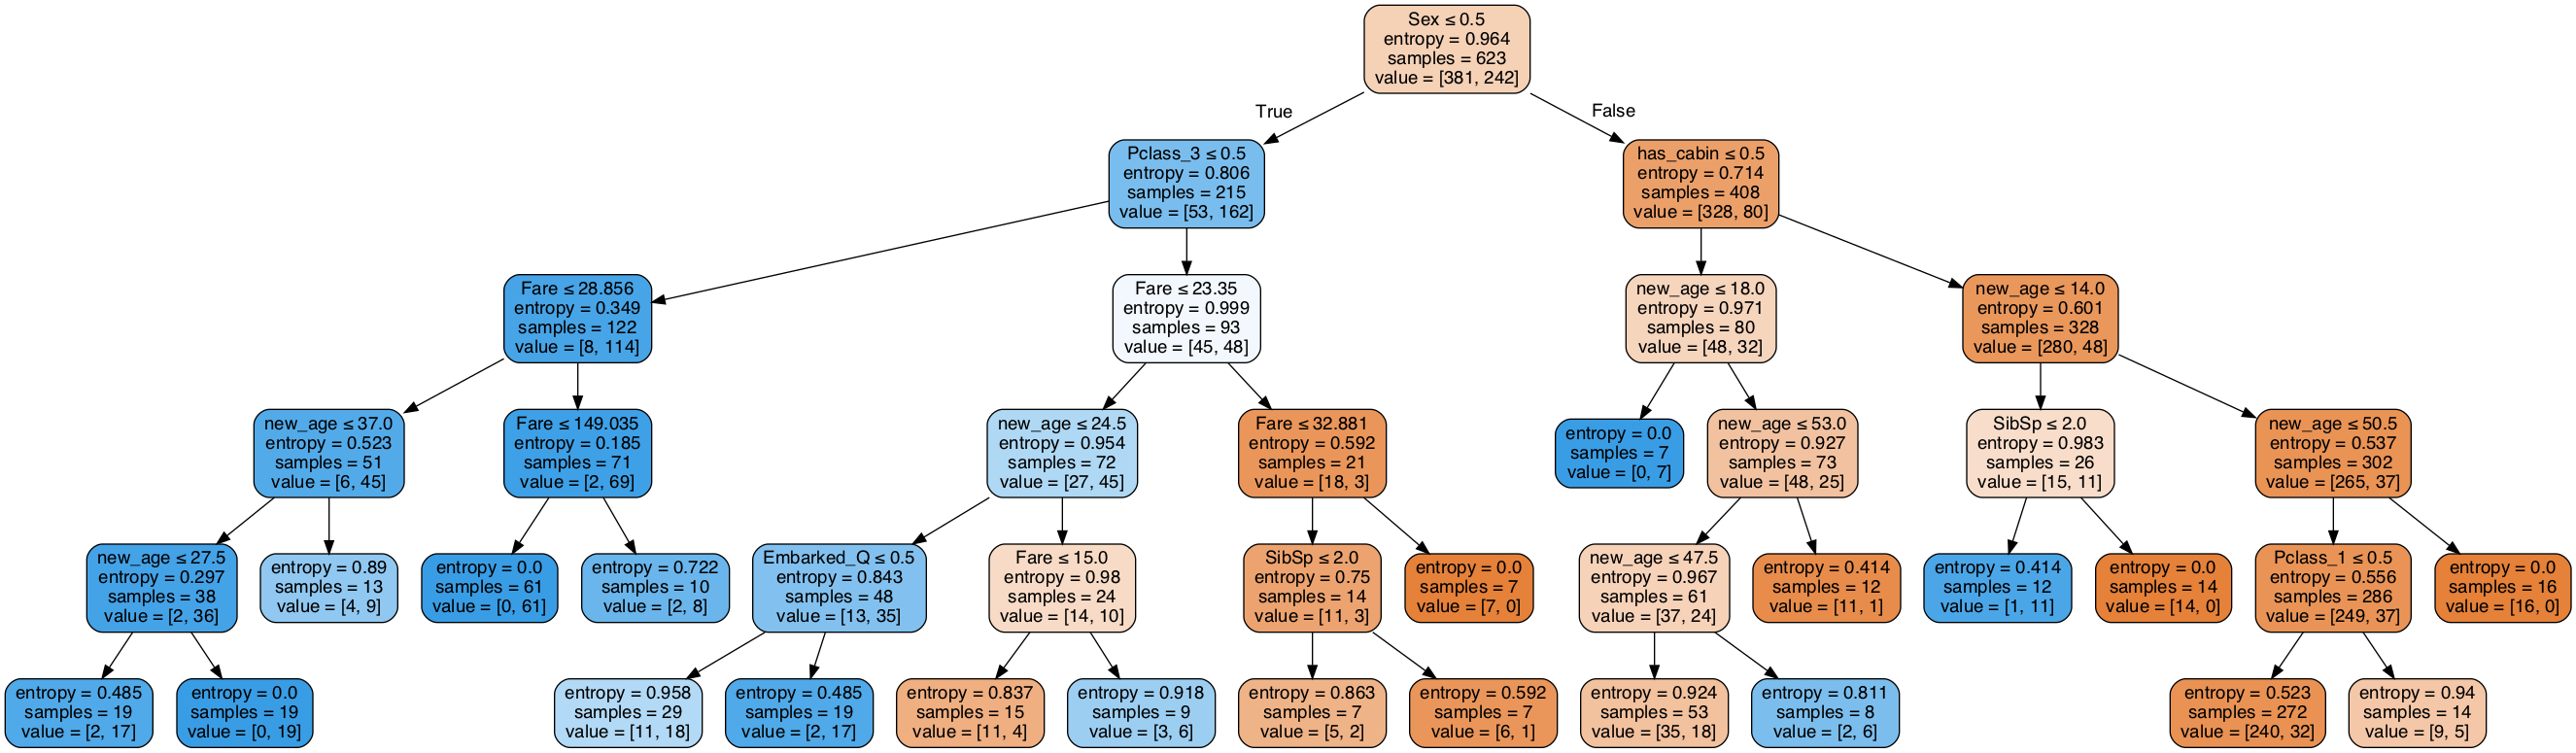

In [14]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(estimator, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())